# Fit with analytical lens light

__last update__: 01/30/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
from astropy.io import fits
from matplotlib.colors import LogNorm, TwoSlopeNorm
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Instrument.psf import PSF
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util, molet_util, util

## Global settings

In [2]:
# Choice of seeing conditions
psf_type = 'gaussian'  # 'gaussian', 'HST'
# Warning: 'HST' will take more time as convolutions are performed in real space... for now.

fix_lens_light = True
fix_linear_params = False

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=5e-3, flux_vmax=1e0, res_vmax=6)

## Simulate the mock data

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [3]:
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/wavelet-lensing-papers/paper_II/molet'
molet_simu_name = f'molet_sim_no_pert'
if psf_type == 'gaussian':
    molet_instru_name = 'gaussian03'
else:
    raise NotImplementedError("MOLET sims with non-gaussian PSFs have not been generated yet.")
    
pixel_grid, noise, psf_molet, data, psi_grid_input, noise_real, source_super, _ \
    = molet_util.read_molet_simulation(molet_dir, molet_simu_name,
                                       use_true_noise_map=False, 
                                       subtract_offset=True,
                                       cut_psf=20)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")
print(f"exposure time : {noise.exposure_map} s")
print(f"background noise level : {noise.background_rms:.3f}")

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec
exposure time : 9600.0 s
background noise level : 0.005


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:22: UserWarning: Using MOLET instrument 'gaussian03'.
  warnings.warn(f"Using MOLET instrument '{instrument_name}'.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:129: UserWarning: Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).
  warnings.warn("Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).")


### Point spread function

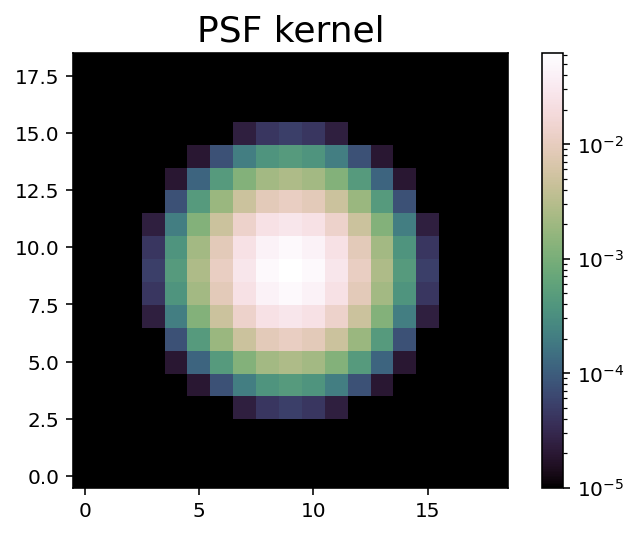

In [4]:
# PSF
if psf_type == 'gaussian':
    # Gaussian PSF
    psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
elif psf_type == 'molet':
    # pixelated PSF used by MOLET
    psf = psf_molet
    
plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

### Mass and light models

In [5]:
# Fitted lens mass model
lens_mass_model_fit = LensModel(['SIE', 'SHEAR'])
kwargs_lens_input = [
    {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
]

# Input lens light model 
lens_light_model_fit = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [{'R_sersic': 1.9949292,
                    'amp': 12.620034,
                    'center_x': -0.00385393,
                    'center_y': -0.00458917,
                    'e1': 0.14911005,
                    'e2': -0.04016396,
                    'n_sersic': 1.9948864}
    ]  

# Input source light
source_model_fit = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 10., 'R_sersic': 0.8, 'n_sersic': 2, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]

### Image model classes, for both simulate and fit

In [6]:
kwargs_numerics = {'supersampling_factor': 1}

# Hybrid image model for fitting
lens_image_fit = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_fit,
                                lens_light_model_class=lens_light_model_fit,
                                kwargs_numerics=kwargs_numerics)

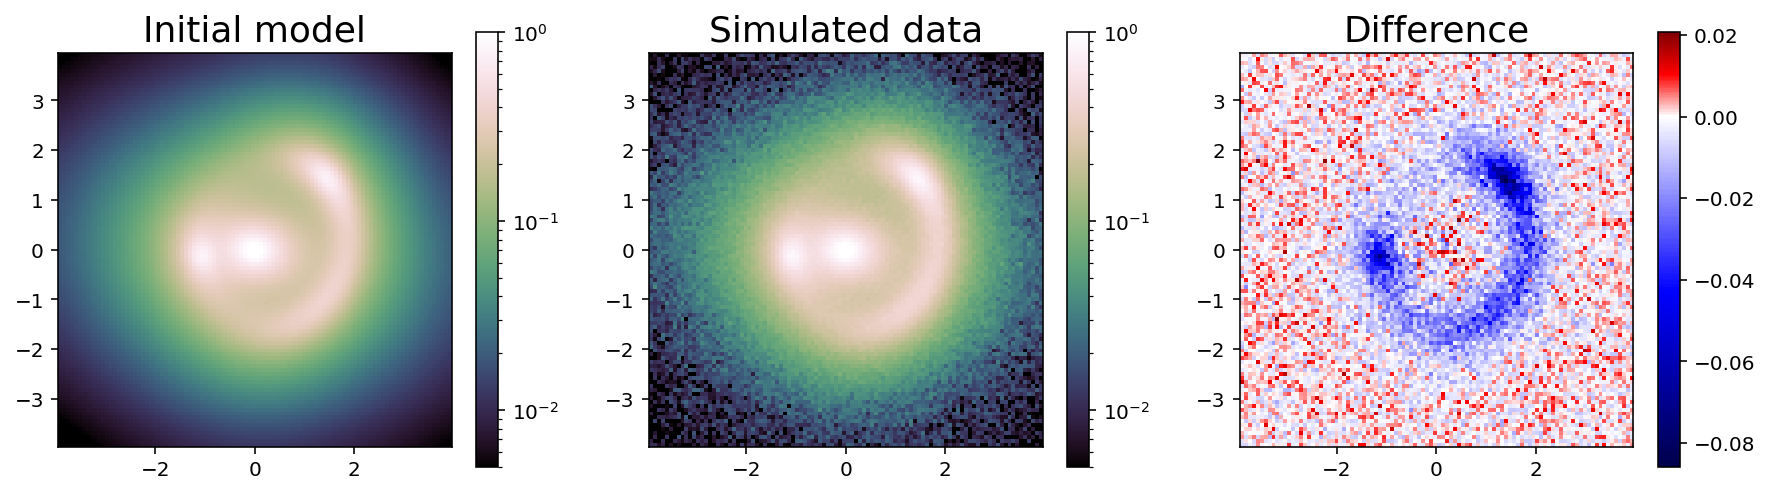

In [7]:
# Generate a lensed image based on source and lens models
initial_model = lens_image_fit.model(kwargs_lens=kwargs_lens_input,
                                     kwargs_source=kwargs_source_input,
                                     kwargs_lens_light=kwargs_lens_light_input)

# get the true source surface brightness
source_input = lens_image_fit.source_surface_brightness(kwargs_source_input,
                                                        de_lensed=True, unconvolved=True)

# inform the plotter for later
plotter.set_data(data)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("Initial model", fontsize=18)
im = ax.imshow(initial_model, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("Simulated data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("Difference", fontsize=18)
im = ax.imshow(initial_model - data, origin='lower', extent=extent, norm=TwoSlopeNorm(0), cmap='seismic')
fig.colorbar(im, ax=ax)
plt.show()

## Model fitting

### Prepare the parameters (initial values, constraints, etc.)

In [8]:
kwargs_init = {
    'kwargs_lens': deepcopy(kwargs_lens_input),
    'kwargs_source': deepcopy(kwargs_source_input),
    'kwargs_lens_light': deepcopy(kwargs_lens_light_input),
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
    
}
if fix_linear_params:
    kwargs_fixed['kwargs_source'] = [{'amp': kwargs_source_input[0]['amp']}]
if fix_lens_light:
    kwargs_fixed['kwargs_lens_light'] = kwargs_lens_light_input
    if fix_linear_params:
        kwargs_fixed['kwargs_lens_light'] = [{'amp': kwargs_lens_light_input[0]['amp']}]
    
kwargs_joint = {
    # fix lens center to lens light center
    'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
}
parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed, kwargs_joint=kwargs_joint)
print("Number of fitted parameters:", parameters.num_parameters)

Number of fitted parameters: 12


### Fit source and macro lens model (if required)

In [9]:
# Create loss
loss = Loss(data, lens_image_fit, parameters, 
            likelihood_type='chi2', 
            #likelihood_type='l2_norm', 
            #likelihood_type='gaussian', 
            prior_terms=None)
print("Initial loss:", loss(parameters.kwargs2args(kwargs_init)))
print("Number of data points in likelihood:", loss.likelihood_num_data_points)

# Optimizer
optimizer = Optimizer(loss, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))
kwargs_smooth_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

minimize.BFGS:   0%|          | 0/1 [00:00<?, ?it/s]

Initial loss: 12739.609
Number of data points in likelihood: 10000


minimize.BFGS: 100%|██████████| 1/1 [00:11<00:00, 11.76s/it]

Runtime: 11.76891803741455
Loss at best-fit: 4944.617


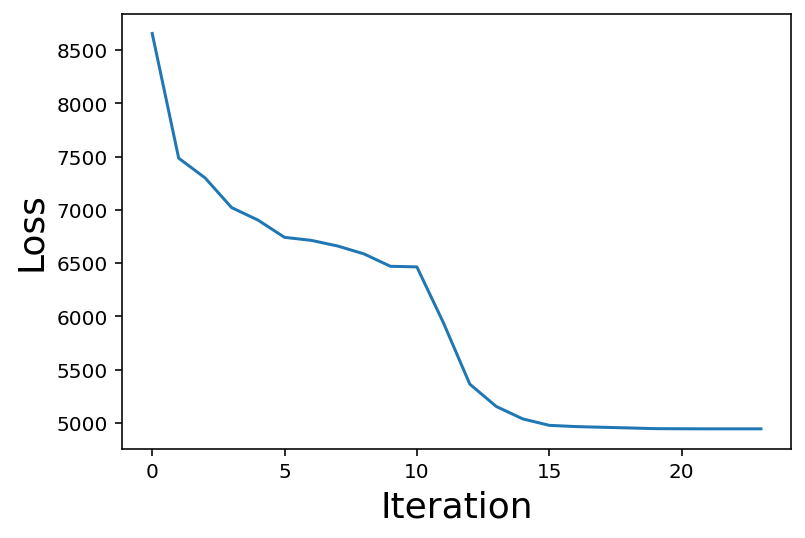

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

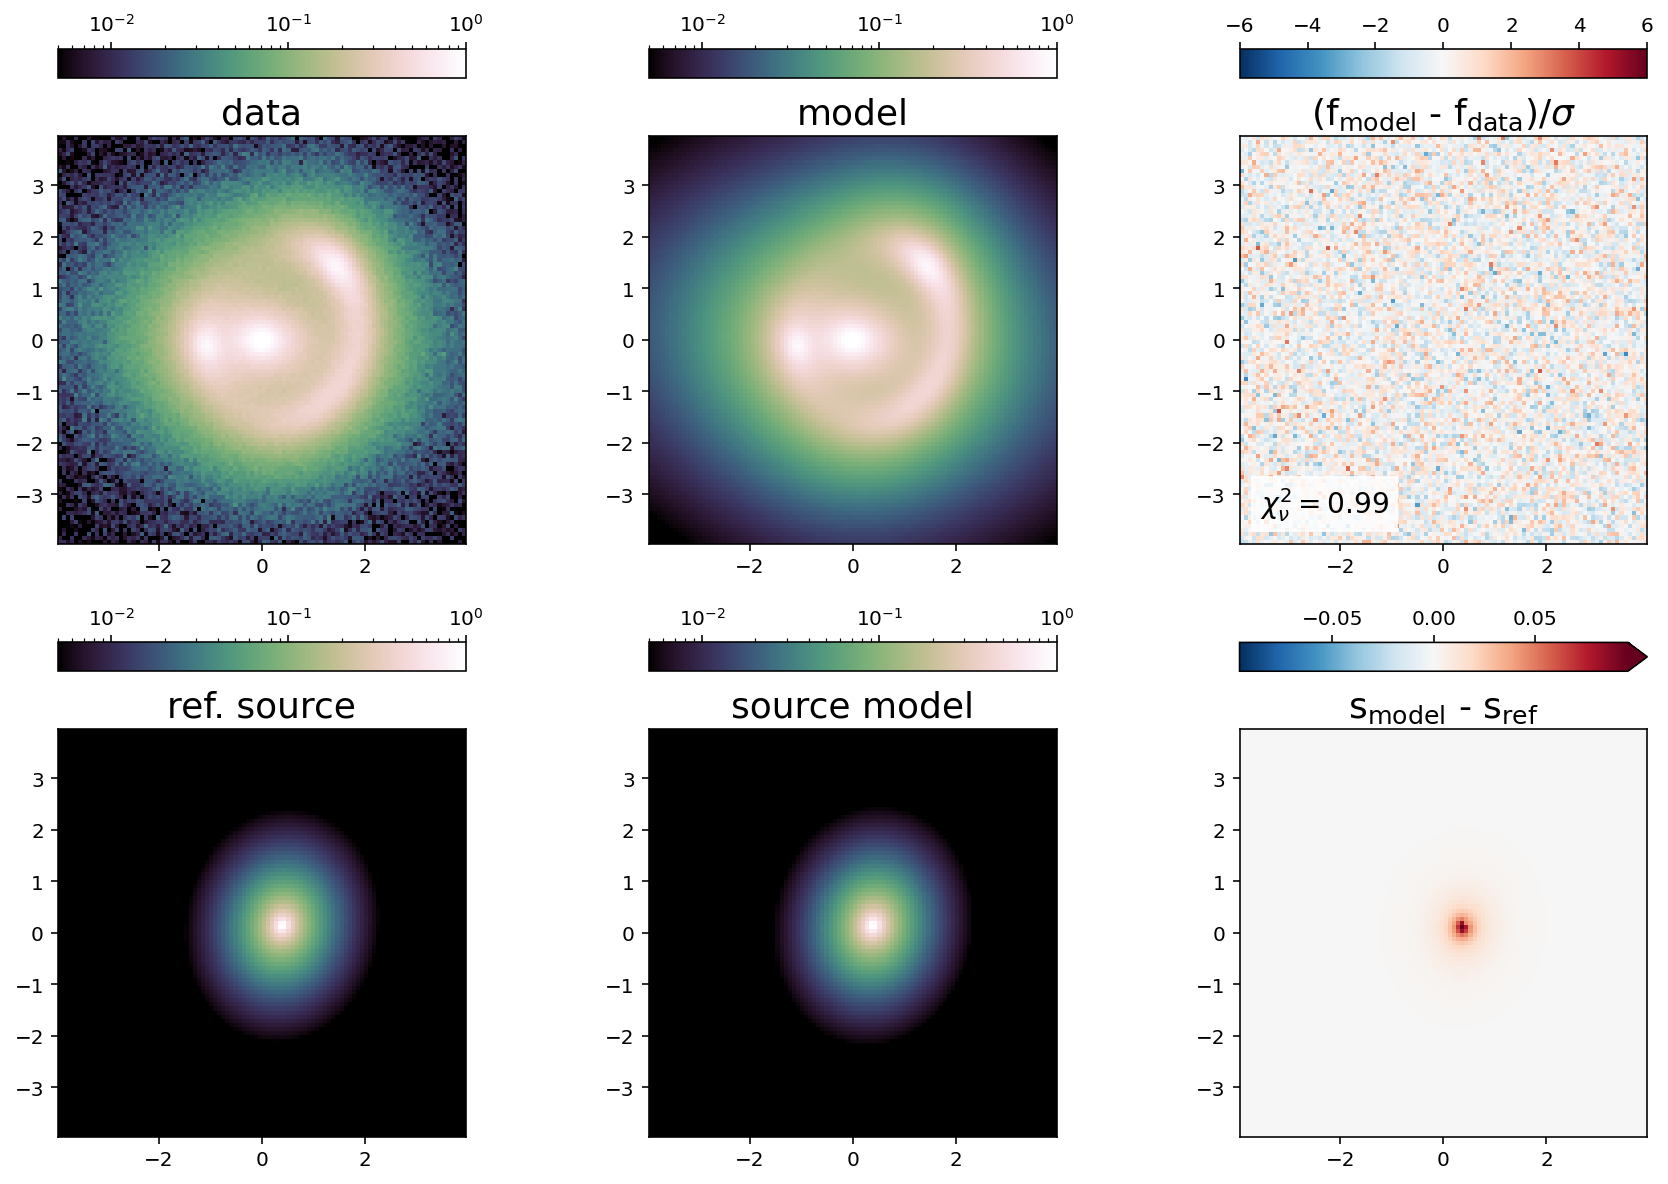

In [11]:
plotter.set_ref_source(source_input)
fig = plotter.model_summary(lens_image_fit, kwargs_smooth_fit, show_source=True)
plt.show()

In [12]:
pprint(kwargs_smooth_fit)

{'kwargs_lens': [{'center_x': -0.00385393,
                  'center_y': -0.00458917,
                  'e1': array(0.14910756, dtype=float32),
                  'e2': array(-0.03971141, dtype=float32),
                  'theta_E': array(1.6005507, dtype=float32)},
                 {'dec_0': 0.0,
                  'gamma1': array(-0.01059017, dtype=float32),
                  'gamma2': array(0.03060045, dtype=float32),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': 1.9949292,
                        'amp': 12.620034,
                        'center_x': -0.00385393,
                        'center_y': -0.00458917,
                        'e1': 0.14911005,
                        'e2': -0.04016396,
                        'n_sersic': 1.9948864}],
 'kwargs_source': [{'R_sersic': array(0.79583335, dtype=float32),
                    'amp': array(11.124026, dtype=float32),
                    'center_x': array(0.3963792, dtype=float32),
                    'center_y': 

## Fisher information estimates

In [13]:
from herculens.Parameters.covariance import FisherCovariance

In [14]:
model_covar = FisherCovariance(parameters, loss)

# Fisher information matrices
model_covar.compute_fisher_information()  # can take time
fisher_matrix = model_covar.fisher_matrix
cov_matrix = model_covar.covariance_matrix

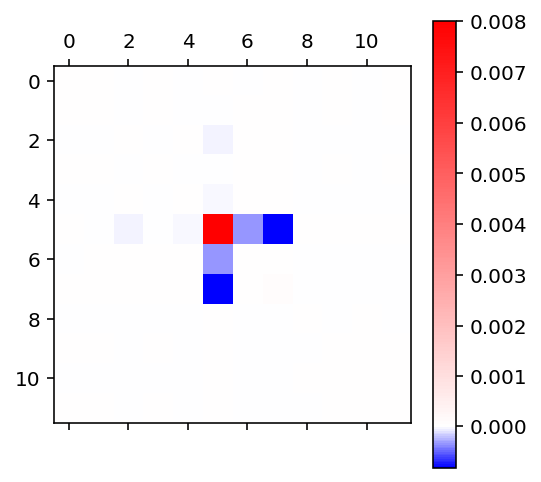

In [15]:
plt.matshow(cov_matrix, cmap='bwr', norm=TwoSlopeNorm(0))
plt.colorbar()
plt.show()

In [16]:
#mean = parameters.current_values()
mean = parameters.kwargs2args(kwargs_smooth_fit)

samples_fim = np.random.multivariate_normal(mean, cov_matrix, size=10000, check_valid='raise')

In [ ]:
rause

## HMC

In [17]:
sampler_hmc = Sampler(loss, parameters)

In [ ]:
#inv_mass_matrix = np.copy(cov_matrix)
inv_mass_matrix = np.abs(np.diag(cov_matrix))
print(inv_mass_matrix.shape)

seed_hmc = 8
samples_hmc, logL_hmc, extra_fields_hmc, runtime \
    = sampler_hmc.hmc_blackjax(seed_hmc, num_warmup=100, num_samples=500, num_chains=1, 
                               restart_from_init=False, sampler_type='NUTS', use_stan_warmup=False,
                               step_size=1e-3, inv_mass_matrix=inv_mass_matrix, num_integ_steps=30)

print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_hmc.shape}")

(12,)


In [ ]:
samples_hmc = sampler_hmc

## Classical MCMC with `emcee`

In [ ]:
# decide on some scatter to initialize emcee walkers
kwargs_std = {
    'kwargs_lens': [{'theta_E': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}, {'gamma1': 0.1, 'gamma2': 0.1}],
    'kwargs_source': [{'amp': 1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1, 'n_sersic': 0.1, 'R_sersic': 0.1}], 
    'kwargs_lens_light': [{'amp': 1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1, 'n_sersic': 0.1, 'R_sersic': 0.1}],
}
init_stds = parameters.kwargs2args(kwargs_std)

# here we need to define a non-jitted log-likelihood function
def log_likelihood_nojit(args):
    # Compute reconstruction with these parameters
    rec = lens_image_fit.model(**parameters.args2kwargs(args))
    noise_var = lens_image_fit.Noise.C_D_model(rec)
    # log-likelihood
    num_data_points = data.size
    log_l = - 0.5 * jnp.sum((data - rec)**2 / noise_var)
    #log_l = - 0.5 * jnp.sum((data - rec)**2)
    # log-prior
    log_l += parameters.log_prior_nojit(args)
    return log_l

In [ ]:
sampler_mcmc = Sampler(loss, parameters)

samples_mcmc, logL_mcmc, extra_fields_mcmc, runtime \
    = sampler_mcmc.mcmc_emcee(log_likelihood_nojit, init_stds, 
                   walker_ratio=10, num_warmup=40, num_samples=100, 
                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_mcmc.shape}")

## Comparison of posteriors

In [ ]:
import corner

kwargs_truths = {'kwargs_lens': kwargs_lens_input, 'kwargs_source': kwargs_source_input, 'kwargs_lens_light': kwargs_lens_light_input}
truths = parameters.kwargs2args(kwargs_truths)

fig = None
fig = corner.corner(samples_fim, truths=truths, show_titles=True, fig=fig,
                    labels=parameters.symbols, color='tab:orange',
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
fig = corner.corner(samples_hmc, truths=truths, show_titles=True, fig=fig,
                    labels=parameters.symbols, color='tab:red',
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
fig = corner.corner(samples_mcmc, truths=truths, show_titles=True, fig=fig,
                    labels=parameters.symbols, color='black',
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})

plt.show()